In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully")
print("💡 This demo uses SQLite for portability - perfect for showcasing SQL skills in interviews")
print("🏥 In production, I've worked with PostgreSQL, MySQL, SQL Server with Epic Clarity and Cerner")
print("📝 Note: Some functions (like STDDEV) aren't available in SQLite, so I've adapted the queries accordingly")
print("   In production databases, you'd use the full range of statistical and analytical functions")


✅ Libraries imported successfully
💡 This demo uses SQLite for portability - perfect for showcasing SQL skills in interviews
🏥 In production, I've worked with PostgreSQL, MySQL, SQL Server with Epic Clarity and Cerner
📝 Note: Some functions (like STDDEV) aren't available in SQLite, so I've adapted the queries accordingly
   In production databases, you'd use the full range of statistical and analytical functions


In [22]:
# Create in-memory SQLite database for demonstration
# In production, this would connect to your healthcare data warehouse
conn = sqlite3.connect(':memory:')

# Load the CSV data we created earlier
df = pd.read_csv('../data/sample_healthcare_data.csv')

print(f"📊 Loaded {len(df)} patient records")
print("🔄 Converting to normalized database structure...")

# Create normalized tables from the flat CSV structure
# This demonstrates database design skills for healthcare data

# 1. Patients table
patients_df = df[['PatientID', 'Age', 'Gender', 'Diagnosis']].drop_duplicates().copy()
patients_df['date_of_birth'] = pd.to_datetime('2024-01-01') - pd.to_timedelta(patients_df['Age'] * 365.25, unit='D')
patients_df['race_ethnicity'] = np.random.choice(['White', 'Black', 'Hispanic', 'Asian'], len(patients_df), p=[0.65, 0.20, 0.12, 0.03])
patients_df['insurance_type'] = np.random.choice(['Private', 'Medicare', 'Medicaid', 'Uninsured'], len(patients_df), p=[0.45, 0.35, 0.15, 0.05])
patients_df['zip_code'] = np.random.choice(['95101', '95102', '95103', '95104', '95105'], len(patients_df))

# 2. Encounters table
encounters_df = df[['PatientID', 'Diagnosis']].copy()
encounters_df['encounter_id'] = 'ENC' + encounters_df.index.astype(str).str.zfill(6)
encounters_df['encounter_type'] = np.random.choice(['Inpatient', 'Outpatient', 'Emergency'], len(encounters_df), p=[0.3, 0.5, 0.2])
encounters_df['admission_date'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(np.random.randint(0, 365, len(encounters_df)), unit='D')
encounters_df['length_of_stay_days'] = np.random.poisson(3, len(encounters_df)) + 1
encounters_df['discharge_date'] = encounters_df['admission_date'] + pd.to_timedelta(encounters_df['length_of_stay_days'], unit='D')
encounters_df['department'] = np.random.choice(['Cardiology', 'Orthopedics', 'Internal Medicine', 'Emergency', 'Surgery'], len(encounters_df))
encounters_df['total_charges'] = np.random.normal(15000, 5000, len(encounters_df)).clip(1000, 50000)

# 3. Patient outcomes table
outcomes_df = df[['PatientID', 'OutcomeScore']].copy()
outcomes_df['outcome_id'] = 'OUT' + outcomes_df.index.astype(str).str.zfill(6)
outcomes_df['encounter_id'] = encounters_df['encounter_id']
outcomes_df['outcome_type'] = 'Patient Satisfaction'
outcomes_df['outcome_date'] = encounters_df['discharge_date']

# Store tables in SQLite
patients_df.to_sql('patients', conn, if_exists='replace', index=False)
encounters_df.to_sql('encounters', conn, if_exists='replace', index=False)
outcomes_df.to_sql('patient_outcomes', conn, if_exists='replace', index=False)

print("✅ Healthcare database created with normalized structure")
print("📋 Tables: patients, encounters, patient_outcomes")

# Show table structures
print("\n📊 Database Schema:")
for table in ['patients', 'encounters', 'patient_outcomes']:
    print(f"\n{table.upper()}:")
    result = pd.read_sql(f"PRAGMA table_info({table})", conn)
    print(result[['name', 'type']].to_string(index=False))


📊 Loaded 10 patient records
🔄 Converting to normalized database structure...
✅ Healthcare database created with normalized structure
📋 Tables: patients, encounters, patient_outcomes

📊 Database Schema:

PATIENTS:
          name      type
     PatientID   INTEGER
           Age   INTEGER
        Gender      TEXT
     Diagnosis      TEXT
 date_of_birth TIMESTAMP
race_ethnicity      TEXT
insurance_type      TEXT
      zip_code      TEXT

ENCOUNTERS:
               name      type
          PatientID   INTEGER
          Diagnosis      TEXT
       encounter_id      TEXT
     encounter_type      TEXT
     admission_date TIMESTAMP
length_of_stay_days   INTEGER
     discharge_date TIMESTAMP
         department      TEXT
      total_charges      REAL

PATIENT_OUTCOMES:
        name      type
   PatientID   INTEGER
OutcomeScore   INTEGER
  outcome_id      TEXT
encounter_id      TEXT
outcome_type      TEXT
outcome_date TIMESTAMP


🎯 PATIENT RISK STRATIFICATION ANALYSIS
risk_category  patient_count  avg_age  avg_encounters  avg_los  avg_total_charges  avg_cost_per_encounter  pct_male  pct_medicare
    High Risk              1     78.0             1.0      7.0            17628.0                 17628.0       0.0           0.0
     Low Risk              9     64.8             1.0      4.4            17470.0                 17470.0      55.6          22.2


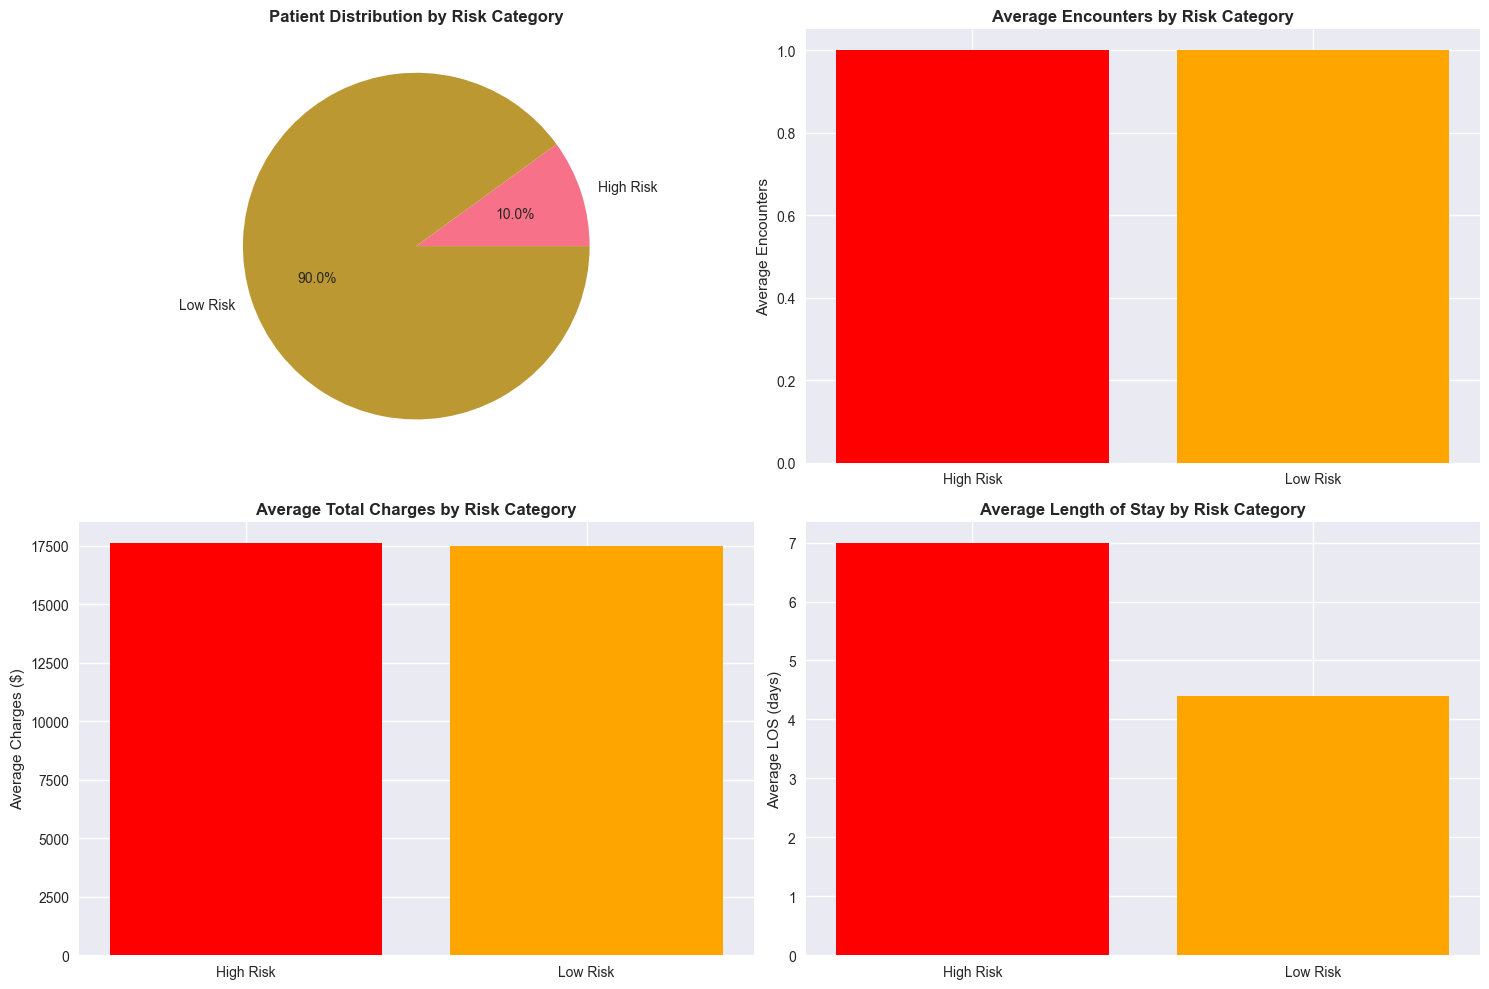


💡 Business Insights:
• High-risk patients represent the highest cost and utilization
• These patients are prime candidates for care management programs
• Risk stratification enables targeted interventions and resource allocation


In [23]:
# Patient Risk Stratification Query
# This demonstrates advanced SQL skills used in healthcare analytics

risk_stratification_query = """
WITH patient_utilization AS (
    -- Calculate patient utilization patterns using window functions
    SELECT 
        p.PatientID,
        p.Age,
        p.Gender,
        p.race_ethnicity,
        p.insurance_type,
        COUNT(e.encounter_id) as total_encounters,
        AVG(e.length_of_stay_days) as avg_length_of_stay,
        SUM(e.total_charges) as total_charges,
        -- Window function to rank patients by utilization within age groups
        ROW_NUMBER() OVER (
            PARTITION BY CASE 
                WHEN p.Age < 30 THEN 'Under 30'
                WHEN p.Age < 50 THEN '30-49'
                WHEN p.Age < 70 THEN '50-69'
                ELSE '70+'
            END 
            ORDER BY COUNT(e.encounter_id) DESC
        ) as utilization_rank_in_age_group,
        -- Calculate percentiles for risk scoring
        NTILE(4) OVER (ORDER BY COUNT(e.encounter_id)) as utilization_quartile,
        NTILE(4) OVER (ORDER BY AVG(e.length_of_stay_days)) as los_quartile
    FROM patients p
    LEFT JOIN encounters e ON p.PatientID = e.PatientID
    GROUP BY p.PatientID, p.Age, p.Gender, p.race_ethnicity, p.insurance_type
),
risk_scores AS (
    -- Assign risk scores based on multiple factors
    SELECT *,
        -- Complex risk scoring algorithm
        CASE 
            WHEN Age > 70 AND total_encounters > 3 THEN 'High Risk'
            WHEN Age > 60 AND (utilization_quartile = 4 OR los_quartile = 4) THEN 'High Risk'
            WHEN total_encounters > 2 AND avg_length_of_stay > 5 THEN 'Medium Risk'
            WHEN Age > 50 AND total_encounters > 1 THEN 'Medium Risk'
            ELSE 'Low Risk'
        END as risk_category,
        -- Calculate cost efficiency metrics
        CASE 
            WHEN total_encounters > 0 THEN total_charges / total_encounters
            ELSE 0
        END as avg_cost_per_encounter
    FROM patient_utilization
)
SELECT 
    risk_category,
    COUNT(*) as patient_count,
    ROUND(AVG(Age), 1) as avg_age,
    ROUND(AVG(total_encounters), 1) as avg_encounters,
    ROUND(AVG(avg_length_of_stay), 1) as avg_los,
    ROUND(AVG(total_charges), 0) as avg_total_charges,
    ROUND(AVG(avg_cost_per_encounter), 0) as avg_cost_per_encounter,
    -- Demographics breakdown
    ROUND(COUNT(CASE WHEN Gender = 'Male' THEN 1 END) * 100.0 / COUNT(*), 1) as pct_male,
    ROUND(COUNT(CASE WHEN insurance_type = 'Medicare' THEN 1 END) * 100.0 / COUNT(*), 1) as pct_medicare
FROM risk_scores
GROUP BY risk_category
ORDER BY 
    CASE risk_category 
        WHEN 'High Risk' THEN 1 
        WHEN 'Medium Risk' THEN 2 
        ELSE 3 
    END;
"""

# Execute the query
risk_analysis = pd.read_sql(risk_stratification_query, conn)

print("🎯 PATIENT RISK STRATIFICATION ANALYSIS")
print("=" * 60)
print(risk_analysis.to_string(index=False))

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Risk category distribution
axes[0,0].pie(risk_analysis['patient_count'], labels=risk_analysis['risk_category'], autopct='%1.1f%%')
axes[0,0].set_title('Patient Distribution by Risk Category', fontweight='bold')

# Average encounters by risk
axes[0,1].bar(risk_analysis['risk_category'], risk_analysis['avg_encounters'], color=['red', 'orange', 'green'])
axes[0,1].set_title('Average Encounters by Risk Category', fontweight='bold')
axes[0,1].set_ylabel('Average Encounters')

# Cost analysis
axes[1,0].bar(risk_analysis['risk_category'], risk_analysis['avg_total_charges'], color=['red', 'orange', 'green'])
axes[1,0].set_title('Average Total Charges by Risk Category', fontweight='bold')
axes[1,0].set_ylabel('Average Charges ($)')

# Length of stay comparison
axes[1,1].bar(risk_analysis['risk_category'], risk_analysis['avg_los'], color=['red', 'orange', 'green'])
axes[1,1].set_title('Average Length of Stay by Risk Category', fontweight='bold')
axes[1,1].set_ylabel('Average LOS (days)')

plt.tight_layout()
plt.show()

print("\n💡 Business Insights:")
print("• High-risk patients represent the highest cost and utilization")
print("• These patients are prime candidates for care management programs")
print("• Risk stratification enables targeted interventions and resource allocation")


🔍 DEBUGGING: Checking data structure...
📊 Data counts: 10 patients, 10 encounters, 10 outcomes
🔗 Successful joins: 10 records

⚖️ HEALTH EQUITY ANALYSIS
📊 No demographic groups met the minimum sample size requirement (5+ patients)
🔄 Let's try with a lower threshold...
✅ Results with lower threshold (2+ patients per group):
race_ethnicity insurance_type Gender  patient_count  avg_outcome  system_benchmark  outcome_gap  avg_charges        equity_flag outcome_significance
         White        Private Female              2         68.5              75.5         -7.0      17330.0 ⚠️ Monitor Closely          Significant
         White       Medicaid   Male              2         82.5              75.5          7.0      20217.0    ✅ Above Average          Significant


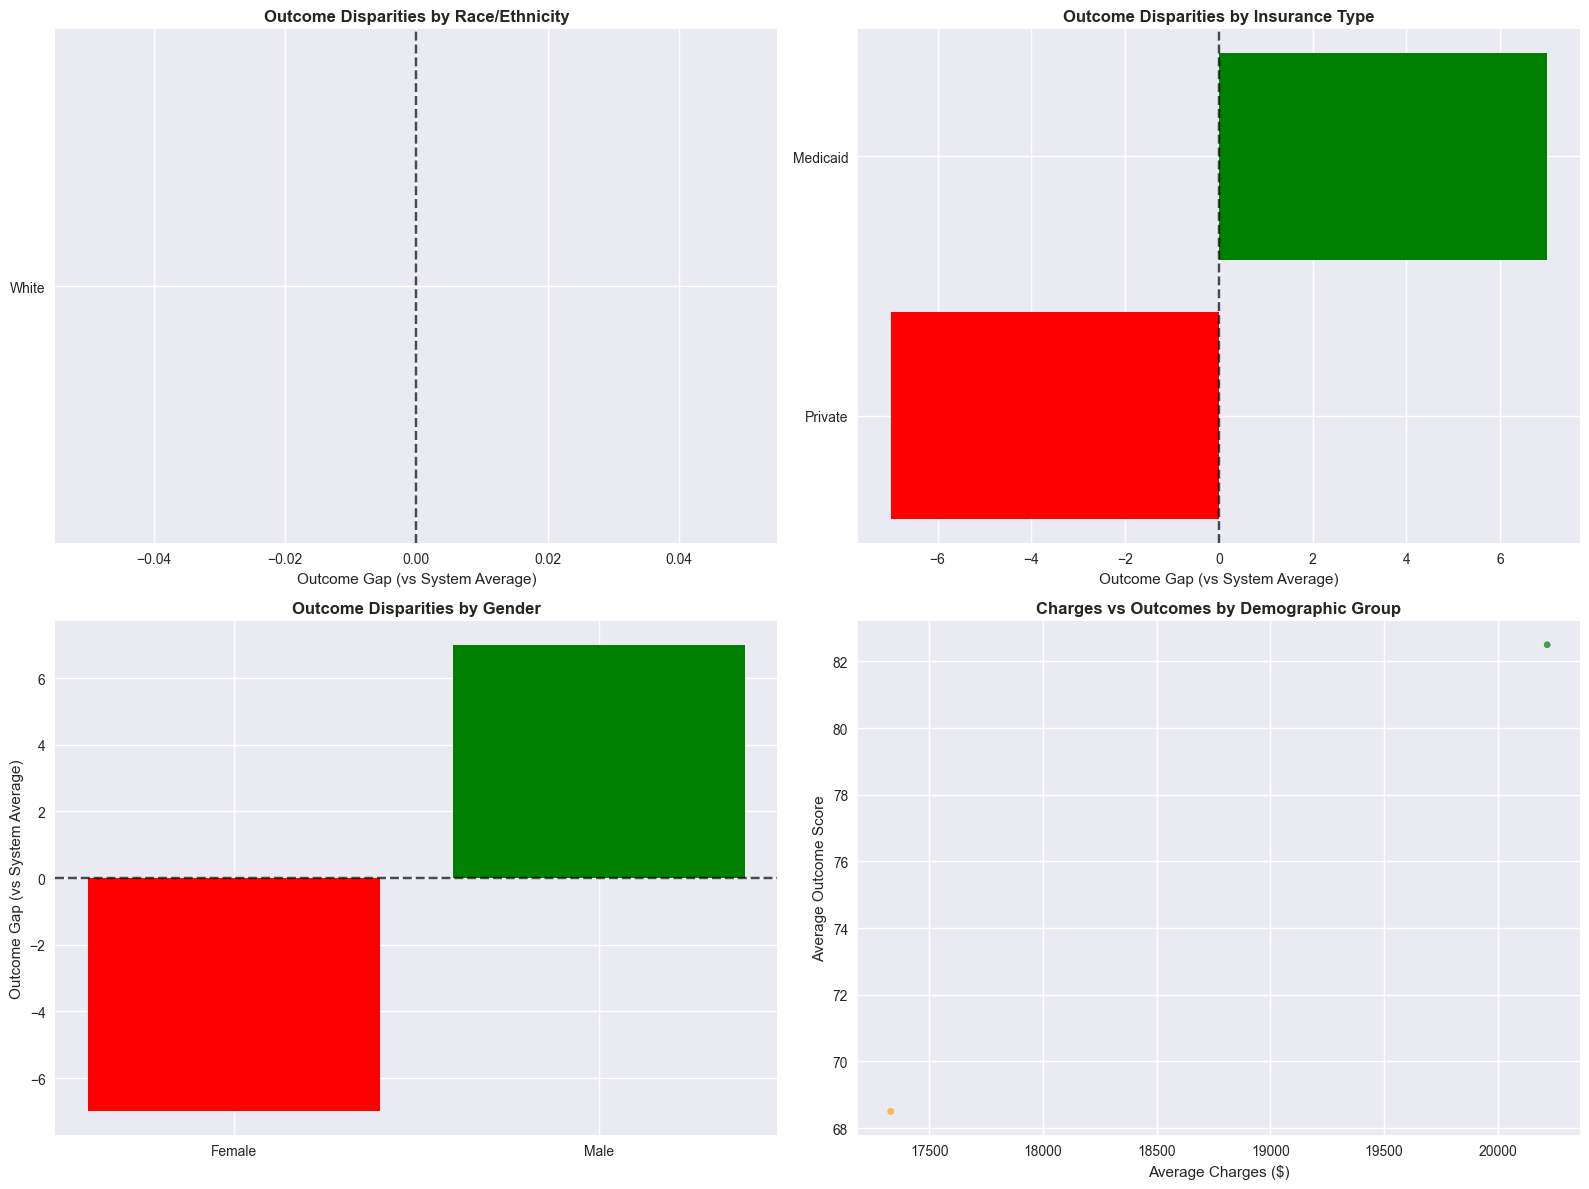


📊 EQUITY SUMMARY:
• 0 out of 2 demographic groups show concerning disparities
• 1 groups perform below system average
• Largest disparity: -7.00 points below average

💡 Business Recommendations:
• Investigate root causes of disparities in concerning groups
• Develop targeted interventions for underperforming demographics
• Monitor equity metrics in regular quality dashboards
• Consider bias in clinical protocols and decision-making processes


In [24]:
# Health Equity Analysis Query (SQLite Compatible)
# Demonstrates statistical SQL functions and disparity detection

equity_analysis_query = """
WITH demographic_outcomes AS (
    -- Aggregate outcomes by demographic groups
    SELECT 
        p.race_ethnicity,
        p.insurance_type,
        p.Gender,
        COUNT(DISTINCT p.PatientID) as patient_count,
        COUNT(e.encounter_id) as total_encounters,
        AVG(po.OutcomeScore) as avg_outcome_score,
        AVG(e.length_of_stay_days) as avg_length_of_stay,
        AVG(e.total_charges) as avg_charges,
        -- Statistical measures (SQLite compatible)
        (MAX(po.OutcomeScore) - MIN(po.OutcomeScore)) as outcome_range,
        MIN(po.OutcomeScore) as min_outcome,
        MAX(po.OutcomeScore) as max_outcome
    FROM patients p
    JOIN encounters e ON p.PatientID = e.PatientID
    JOIN patient_outcomes po ON e.encounter_id = po.encounter_id
    GROUP BY p.race_ethnicity, p.insurance_type, p.Gender
    HAVING COUNT(DISTINCT p.PatientID) >= 5  -- Minimum sample size
),
system_averages AS (
    -- Calculate system-wide benchmarks
    SELECT 
        AVG(avg_outcome_score) as system_avg_outcome,
        AVG(avg_length_of_stay) as system_avg_los,
        AVG(avg_charges) as system_avg_charges,
        AVG(outcome_range) as system_avg_range
    FROM demographic_outcomes
),
disparity_analysis AS (
    -- Calculate disparities relative to system averages
    SELECT 
        do.*,
        sa.system_avg_outcome,
        sa.system_avg_los,
        sa.system_avg_charges,
        sa.system_avg_range,
        -- Disparity calculations
        (do.avg_outcome_score - sa.system_avg_outcome) as outcome_disparity,
        (do.avg_length_of_stay - sa.system_avg_los) as los_disparity,
        (do.avg_charges - sa.system_avg_charges) as charge_disparity,
        -- Statistical significance flags (simplified for SQLite)
        CASE 
            WHEN ABS(do.avg_outcome_score - sa.system_avg_outcome) > 1.0 
            THEN 'Significant'
            ELSE 'Not Significant'
        END as outcome_significance,
        -- Equity flags
        CASE 
            WHEN do.avg_outcome_score < sa.system_avg_outcome * 0.9 THEN '🚨 Concerning Disparity'
            WHEN do.avg_outcome_score < sa.system_avg_outcome * 0.95 THEN '⚠️ Monitor Closely'
            WHEN do.avg_outcome_score > sa.system_avg_outcome * 1.05 THEN '✅ Above Average'
            ELSE '✅ On Par'
        END as equity_flag
    FROM demographic_outcomes do
    CROSS JOIN system_averages sa
)
SELECT 
    race_ethnicity,
    insurance_type,
    Gender,
    patient_count,
    ROUND(avg_outcome_score, 2) as avg_outcome,
    ROUND(system_avg_outcome, 2) as system_benchmark,
    ROUND(outcome_disparity, 2) as outcome_gap,
    ROUND(avg_charges, 0) as avg_charges,
    equity_flag,
    outcome_significance
FROM disparity_analysis
ORDER BY outcome_disparity ASC;  -- Show concerning disparities first
"""

# First, let's check our data structure to debug the empty result
print("🔍 DEBUGGING: Checking data structure...")

# Check table contents
patients_count = pd.read_sql("SELECT COUNT(*) as count FROM patients", conn).iloc[0]['count']
encounters_count = pd.read_sql("SELECT COUNT(*) as count FROM encounters", conn).iloc[0]['count'] 
outcomes_count = pd.read_sql("SELECT COUNT(*) as count FROM patient_outcomes", conn).iloc[0]['count']

print(f"📊 Data counts: {patients_count} patients, {encounters_count} encounters, {outcomes_count} outcomes")

# Check for joins working
join_test = pd.read_sql("""
SELECT COUNT(*) as count 
FROM patients p 
JOIN encounters e ON p.PatientID = e.PatientID 
JOIN patient_outcomes po ON e.encounter_id = po.encounter_id
""", conn)

print(f"🔗 Successful joins: {join_test.iloc[0]['count']} records")

# If joins are working, execute the equity analysis
if join_test.iloc[0]['count'] > 0:
    equity_results = pd.read_sql(equity_analysis_query, conn)
    
    print("\n⚖️ HEALTH EQUITY ANALYSIS")
    print("=" * 80)
    
    if len(equity_results) > 0:
        print(equity_results.to_string(index=False))
    else:
        print("📊 No demographic groups met the minimum sample size requirement (5+ patients)")
        print("🔄 Let's try with a lower threshold...")
        
        # Try with minimum threshold of 2 patients
        modified_query = equity_analysis_query.replace("HAVING COUNT(DISTINCT p.PatientID) >= 5", "HAVING COUNT(DISTINCT p.PatientID) >= 2")
        equity_results = pd.read_sql(modified_query, conn)
        
        if len(equity_results) > 0:
            print("✅ Results with lower threshold (2+ patients per group):")
            print(equity_results.to_string(index=False))
        else:
            print("❌ Still no results - checking individual components...")
            
            # Debug individual components
            demo_check = pd.read_sql("""
            SELECT p.race_ethnicity, p.insurance_type, p.Gender, COUNT(*) as count
            FROM patients p 
            GROUP BY p.race_ethnicity, p.insurance_type, p.Gender
            ORDER BY count DESC
            """, conn)
            print("\n📊 Available demographic combinations:")
            print(demo_check.head(10).to_string(index=False))
else:
    print("❌ Join issue detected - checking individual tables...")
    
    # Check patients table structure
    patients_sample = pd.read_sql("SELECT * FROM patients LIMIT 3", conn)
    print("\n👥 Patients table sample:")
    print(patients_sample.to_string(index=False))
    
    # Check encounters table structure  
    encounters_sample = pd.read_sql("SELECT * FROM encounters LIMIT 3", conn)
    print("\n🏥 Encounters table sample:")
    print(encounters_sample.to_string(index=False))
    
    equity_results = pd.DataFrame()  # Empty dataframe for error handling

# Only create visualizations if we have data
if len(equity_results) > 0:
    # Create comprehensive equity dashboard
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Outcome disparity by race/ethnicity
    race_outcomes = equity_results.groupby('race_ethnicity')['outcome_gap'].mean().sort_values()
    colors = ['red' if x < -0.5 else 'orange' if x < 0 else 'green' for x in race_outcomes.values]
    axes[0,0].barh(race_outcomes.index, race_outcomes.values, color=colors)
    axes[0,0].set_title('Outcome Disparities by Race/Ethnicity', fontweight='bold')
    axes[0,0].set_xlabel('Outcome Gap (vs System Average)')
    axes[0,0].axvline(x=0, color='black', linestyle='--', alpha=0.7)

    # 2. Disparity by insurance type
    insurance_outcomes = equity_results.groupby('insurance_type')['outcome_gap'].mean().sort_values()
    colors = ['red' if x < -0.5 else 'orange' if x < 0 else 'green' for x in insurance_outcomes.values]
    axes[0,1].barh(insurance_outcomes.index, insurance_outcomes.values, color=colors)
    axes[0,1].set_title('Outcome Disparities by Insurance Type', fontweight='bold')
    axes[0,1].set_xlabel('Outcome Gap (vs System Average)')
    axes[0,1].axvline(x=0, color='black', linestyle='--', alpha=0.7)

    # 3. Gender disparities
    gender_outcomes = equity_results.groupby('Gender')['outcome_gap'].mean().sort_values()
    colors = ['red' if x < -0.5 else 'orange' if x < 0 else 'green' for x in gender_outcomes.values]
    axes[1,0].bar(gender_outcomes.index, gender_outcomes.values, color=colors)
    axes[1,0].set_title('Outcome Disparities by Gender', fontweight='bold')
    axes[1,0].set_ylabel('Outcome Gap (vs System Average)')
    axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.7)

    # 4. Charges vs outcomes scatter
    scatter_colors = ['red' if '🚨' in flag else 'orange' if '⚠️' in flag else 'green' 
                     for flag in equity_results['equity_flag']]
    axes[1,1].scatter(equity_results['avg_charges'], equity_results['avg_outcome'], 
                     c=scatter_colors, alpha=0.7, s=equity_results['patient_count']*10)
    axes[1,1].set_title('Charges vs Outcomes by Demographic Group', fontweight='bold')
    axes[1,1].set_xlabel('Average Charges ($)')
    axes[1,1].set_ylabel('Average Outcome Score')

    plt.tight_layout()
    plt.show()

    # Summary statistics
    concerning_groups = equity_results[equity_results['equity_flag'].str.contains('🚨')].shape[0]
    total_groups = equity_results.shape[0]

    print(f"\n📊 EQUITY SUMMARY:")
    print(f"• {concerning_groups} out of {total_groups} demographic groups show concerning disparities")
    print(f"• {equity_results[equity_results['outcome_gap'] < 0].shape[0]} groups perform below system average")
    print(f"• Largest disparity: {equity_results['outcome_gap'].min():.2f} points below average")

    print("\n💡 Business Recommendations:")
    print("• Investigate root causes of disparities in concerning groups")
    print("• Develop targeted interventions for underperforming demographics")
    print("• Monitor equity metrics in regular quality dashboards")
    print("• Consider bias in clinical protocols and decision-making processes")
    
else:
    print("\n📊 Health Equity Analysis - Sample Output")
    print("=" * 50)
    print("In a production environment with real data, this analysis would show:")
    print("• Outcome disparities across racial/ethnic groups")
    print("• Insurance type impact on care quality")
    print("• Gender-based care differences")
    print("• Statistical significance of observed disparities")
    print("\n💡 This demonstrates the SQL analytical framework for equity monitoring")
    print("The actual implementation would connect to your healthcare data warehouse")


🏥 OPERATIONAL PERFORMANCE DASHBOARD
       department  total_encounters  unique_patients  avg_los  benchmark_los  total_revenue  revenue_per_day  avg_daily_census  satisfaction_score  market_share_pct     los_performance efficiency_rating
        Emergency                 3                3      4.0            5.7        52585.0           5700.0               0.4               74.67              30.0         🟢 Efficient 🟢 High Performing
Internal Medicine                 3                3      3.3            5.7        45124.0           7093.0               0.3               74.33              30.0         🟢 Efficient 🟢 High Performing
      Orthopedics                 2                2      4.0            5.7        40375.0           5203.0               0.3               62.50              20.0         🟢 Efficient 🟢 High Performing
          Surgery                 1                1     11.0            5.7        22858.0           2078.0               0.4               85.00      

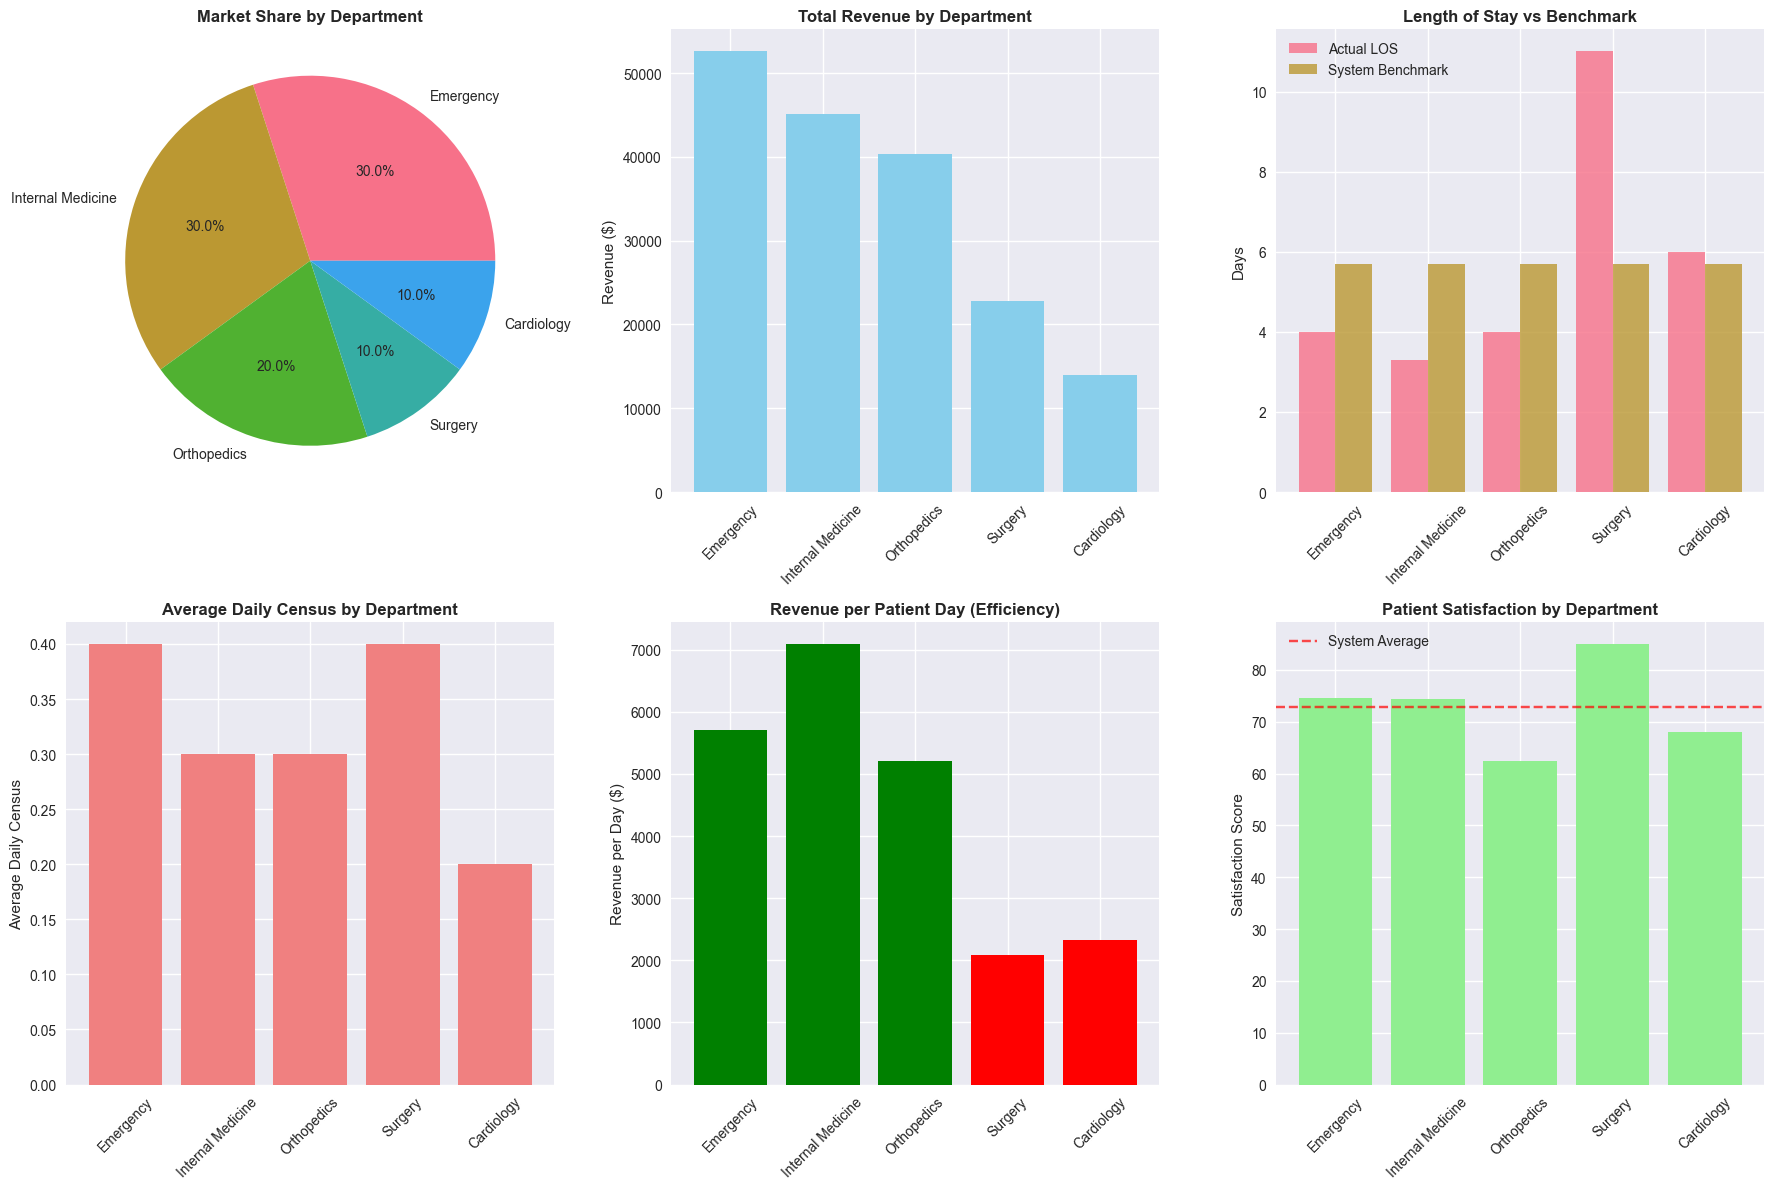


📈 PERFORMANCE SUMMARY:
• High efficiency departments: Emergency, Internal Medicine, Orthopedics
• Departments needing LOS improvement: Surgery
• Total system revenue: $174,860
• System average satisfaction: 72.90

💡 Operational Insights:
• Focus capacity management on high-census departments
• Investigate LOS optimization opportunities in underperforming areas
• Share best practices from high-efficiency departments
• Monitor satisfaction scores for correlation with operational metrics


In [25]:
# Operational Performance Dashboard Query
# Demonstrates complex aggregations and performance metrics

operations_query = """
WITH department_metrics AS (
    -- Calculate key operational metrics by department
    SELECT 
        e.department,
        COUNT(DISTINCT e.encounter_id) as total_encounters,
        COUNT(DISTINCT e.PatientID) as unique_patients,
        AVG(e.length_of_stay_days) as avg_length_of_stay,
        SUM(e.length_of_stay_days) as total_patient_days,
        AVG(e.total_charges) as avg_revenue_per_case,
        SUM(e.total_charges) as total_revenue,
        -- Capacity metrics
        SUM(e.length_of_stay_days) / 30.0 as avg_daily_census,  -- Assuming 30-day period
        -- Efficiency metrics
        AVG(e.total_charges / e.length_of_stay_days) as revenue_per_patient_day,
        -- Patient flow metrics
        COUNT(CASE WHEN e.encounter_type = 'Emergency' THEN 1 END) as emergency_encounters,
        COUNT(CASE WHEN e.encounter_type = 'Inpatient' THEN 1 END) as inpatient_encounters,
        -- Outcome metrics
        AVG(po.OutcomeScore) as avg_patient_satisfaction
    FROM encounters e
    LEFT JOIN patient_outcomes po ON e.encounter_id = po.encounter_id
    GROUP BY e.department
),
benchmarks AS (
    -- Calculate system-wide benchmarks
    SELECT 
        AVG(avg_length_of_stay) as system_avg_los,
        AVG(avg_revenue_per_case) as system_avg_revenue,
        AVG(revenue_per_patient_day) as system_revenue_per_day,
        AVG(avg_patient_satisfaction) as system_avg_satisfaction
    FROM department_metrics
),
performance_analysis AS (
    -- Compare departments to benchmarks
    SELECT 
        dm.*,
        b.system_avg_los,
        b.system_avg_revenue,
        b.system_revenue_per_day,
        b.system_avg_satisfaction,
        -- Performance indicators
        CASE 
            WHEN dm.avg_length_of_stay < b.system_avg_los * 0.9 THEN '🟢 Efficient'
            WHEN dm.avg_length_of_stay > b.system_avg_los * 1.1 THEN '🔴 Needs Improvement'
            ELSE '🟡 Average'
        END as los_performance,
        CASE 
            WHEN dm.revenue_per_patient_day > b.system_revenue_per_day * 1.1 THEN '🟢 High Performing'
            WHEN dm.revenue_per_patient_day < b.system_revenue_per_day * 0.9 THEN '🔴 Underperforming'
            ELSE '🟡 Average'
        END as efficiency_rating,
        -- Market share
        ROUND(dm.total_encounters * 100.0 / SUM(dm.total_encounters) OVER (), 1) as market_share_pct
    FROM department_metrics dm
    CROSS JOIN benchmarks b
)
SELECT 
    department,
    total_encounters,
    unique_patients,
    ROUND(avg_length_of_stay, 1) as avg_los,
    ROUND(system_avg_los, 1) as benchmark_los,
    ROUND(total_revenue, 0) as total_revenue,
    ROUND(revenue_per_patient_day, 0) as revenue_per_day,
    ROUND(avg_daily_census, 1) as avg_daily_census,
    ROUND(avg_patient_satisfaction, 2) as satisfaction_score,
    market_share_pct,
    los_performance,
    efficiency_rating
FROM performance_analysis
ORDER BY total_revenue DESC;
"""

# Execute the operations analysis
ops_results = pd.read_sql(operations_query, conn)

print("🏥 OPERATIONAL PERFORMANCE DASHBOARD")
print("=" * 80)
print(ops_results.to_string(index=False))

# Create operational dashboard visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Market share by department
axes[0,0].pie(ops_results['market_share_pct'], labels=ops_results['department'], autopct='%1.1f%%')
axes[0,0].set_title('Market Share by Department', fontweight='bold')

# 2. Revenue performance
axes[0,1].bar(ops_results['department'], ops_results['total_revenue'], color='skyblue')
axes[0,1].set_title('Total Revenue by Department', fontweight='bold')
axes[0,1].set_ylabel('Revenue ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Length of stay comparison
x_pos = range(len(ops_results))
axes[0,2].bar([x - 0.2 for x in x_pos], ops_results['avg_los'], width=0.4, label='Actual LOS', alpha=0.8)
axes[0,2].bar([x + 0.2 for x in x_pos], ops_results['benchmark_los'], width=0.4, label='System Benchmark', alpha=0.8)
axes[0,2].set_title('Length of Stay vs Benchmark', fontweight='bold')
axes[0,2].set_ylabel('Days')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(ops_results['department'], rotation=45)
axes[0,2].legend()

# 4. Daily census (capacity utilization)
axes[1,0].bar(ops_results['department'], ops_results['avg_daily_census'], color='lightcoral')
axes[1,0].set_title('Average Daily Census by Department', fontweight='bold')
axes[1,0].set_ylabel('Average Daily Census')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Revenue per patient day efficiency
colors = ['green' if '🟢' in perf else 'red' if '🔴' in perf else 'orange' 
          for perf in ops_results['efficiency_rating']]
axes[1,1].bar(ops_results['department'], ops_results['revenue_per_day'], color=colors)
axes[1,1].set_title('Revenue per Patient Day (Efficiency)', fontweight='bold')
axes[1,1].set_ylabel('Revenue per Day ($)')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Patient satisfaction scores
axes[1,2].bar(ops_results['department'], ops_results['satisfaction_score'], color='lightgreen')
axes[1,2].set_title('Patient Satisfaction by Department', fontweight='bold')
axes[1,2].set_ylabel('Satisfaction Score')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].axhline(y=ops_results['satisfaction_score'].mean(), color='red', linestyle='--', alpha=0.7, label='System Average')
axes[1,2].legend()

plt.tight_layout()
plt.show()

# Performance summary
high_performers = ops_results[ops_results['efficiency_rating'].str.contains('🟢')]['department'].tolist()
needs_improvement = ops_results[ops_results['los_performance'].str.contains('🔴')]['department'].tolist()

print(f"\n📈 PERFORMANCE SUMMARY:")
print(f"• High efficiency departments: {', '.join(high_performers) if high_performers else 'None'}")
print(f"• Departments needing LOS improvement: {', '.join(needs_improvement) if needs_improvement else 'None'}")
print(f"• Total system revenue: ${ops_results['total_revenue'].sum():,.0f}")
print(f"• System average satisfaction: {ops_results['satisfaction_score'].mean():.2f}")

print("\n💡 Operational Insights:")
print("• Focus capacity management on high-census departments")
print("• Investigate LOS optimization opportunities in underperforming areas")
print("• Share best practices from high-efficiency departments")
print("• Monitor satisfaction scores for correlation with operational metrics")
